# Visualization

In [147]:
import sys
import pathlib

In [698]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from shapely import affinity
import contextily as cx
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.image as mpimg
from PIL import Image
from scipy import ndimage

In [149]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
sys.path.append("..")

In [454]:
from src.trajectory import point_to_bbox
from src.utils import WorldDefinition

## Read data

In [152]:
data_path = "../data/raw/rdb1.parquet"

In [153]:
df = pd.read_parquet(data_path)

In [154]:
df.head()

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,table
0,0,1,0.000000,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217,rdb1_1
1,1,2,0.033367,1,619302.47,5809133.85,0.452985,4.75,0.1341,-0.1156,0.0679,Heavy Vehicle,2.7892,6.0217,rdb1_1
2,2,3,0.066733,1,619302.61,5809133.91,0.452485,4.75,0.1316,-0.1063,0.0776,Heavy Vehicle,2.7892,6.0217,rdb1_1
3,3,4,0.100100,1,619302.76,5809133.98,0.451985,4.75,0.1368,-0.0920,0.1013,Heavy Vehicle,2.7892,6.0217,rdb1_1
4,4,5,0.133467,1,619302.90,5809134.05,0.451485,4.76,0.1568,-0.0729,0.1388,Heavy Vehicle,2.7892,6.0217,rdb1_1


## Visualize multiple traces

Turn each object trace into into a line string

In [155]:
def generate_trace(group: pd.DataFrame) -> pd.Series:
    
    group = group.sort_values("TIMESTAMP")
    x_arr = group["UTM_X"]
    y_arr = group["UTM_Y"]
    ls = LineString([(x, y) for x, y in zip(x_arr, y_arr)])
    
    first_row = group.iloc[0]
    
    objid = first_row["OBJID"]
    obj_class = first_row["CLASS"]
    w = first_row["WIDTH"]
    l = first_row["LENGTH"]
    
    s = pd.Series({
        "OBJID": objid,
        "CLASS": obj_class,
        "WIDTH": w,
        "LENGTH": l,
        "geometry": ls
    })
    return s

In [156]:
generate_trace(df.query("OBJID==1"))

OBJID                                                       1
CLASS                                           Heavy Vehicle
WIDTH                                                  2.7892
LENGTH                                                 6.0217
geometry    LINESTRING (619302.33 5809133.78, 619302.47 58...
dtype: object

In [157]:
df_traces = df.groupby("OBJID").apply(generate_trace)

In [158]:
df_traces = gpd.GeoDataFrame(df_traces)
df_traces = df_traces.set_crs('EPSG:32632')

Plot all traces in one image

<AxesSubplot:>

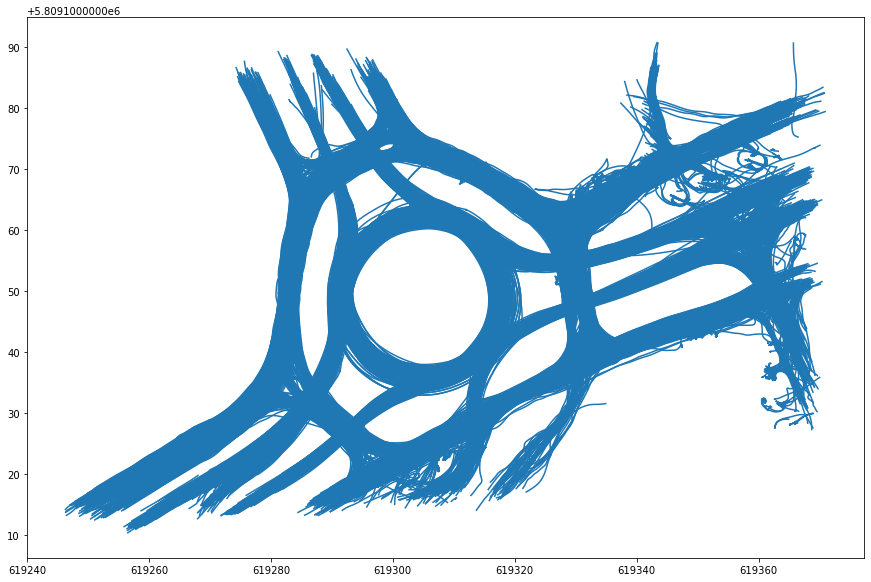

In [29]:
fig, ax = plt.subplots(figsize=(15, 10))
df_traces.plot(ax=ax)

### Class

Plot traces per class

In [31]:
df_traces["CLASS"].value_counts()

Car               26879
Medium Vehicle     2630
Pedestrian          963
Bicycle             831
Bus                 551
Trailer             529
Heavy Vehicle       347
Motorcycle          143
Name: CLASS, dtype: int64

In [58]:
color_cycler = plt.rcParams['axes.prop_cycle']

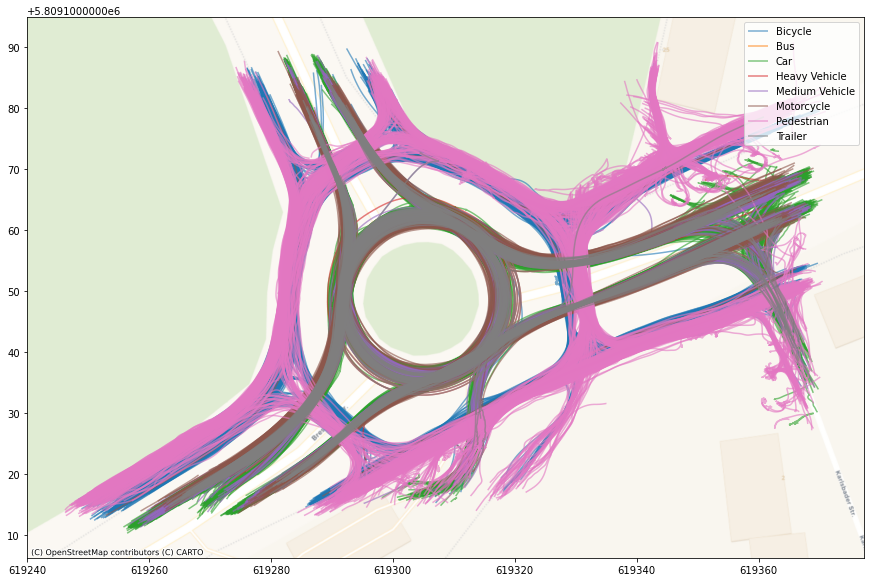

In [63]:
fig, ax = plt.subplots(figsize=(15, 10))
for (class_name, group), c in zip(df_traces.groupby("CLASS"), color_cycler):
    group.plot(ax=ax, label=class_name, color=c["color"], alpha=0.6)
cx.add_basemap(ax, crs=df_traces.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom="auto")
ax.legend()

### Motorized vehicles

In [64]:
df_traces_vehicle = df_traces[df_traces["CLASS"].isin(["Bus", "Car", "Medium Vehicle", "Heavy Vehicle", "Motorcycle"])]

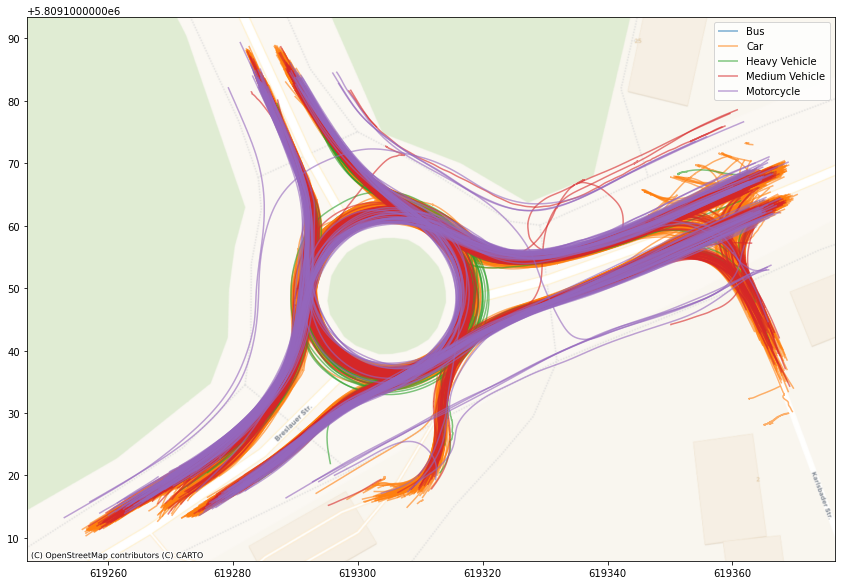

In [65]:
fig, ax = plt.subplots(figsize=(15, 10))
for (class_name, group), c in zip(df_traces_vehicle.groupby("CLASS"), color_cycler):
    group.plot(ax=ax, label=class_name, color=c["color"], alpha=0.6)
cx.add_basemap(ax, crs=df_traces_vehicle.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom="auto")
ax.legend()

## Visualize single timestamp

In [313]:
# 'nearest' interpolation strategy
df["k"] = (df["TIMESTAMP"]*1000 / 33.333).round().astype(int)

In [342]:
df_t = df[(df["k"] == 5001) & (df["table"] == "rdb1_2")]

In [343]:
gdf_t = gpd.GeoDataFrame(
    df_t, geometry=gpd.points_from_xy(df_t["UTM_X"], df_t["UTM_Y"]), crs='EPSG:25832')

In [344]:
gdf_t["bbox"] = gdf_t.apply(lambda row: point_to_bbox(row.geometry, row["WIDTH"], row["LENGTH"], row["UTM_ANGLE"]), axis=1)

In [358]:
gdf_t.head()

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,table,k,geometry,bbox
231987,13476,13477,166.699867,372,619346.89,5809165.17,2.833585,0.05,0.1806,-0.0509,-0.1733,Car,1.9375,4.2212,rdb1_2,5001,POINT (619346.890 5809165.170),"POLYGON ((619344.5850391756 5809164.886690066,..."
298760,80249,80250,166.699867,445,619365.82,5809150.30,0.449585,1.56,0.0148,-0.0133,0.0065,Pedestrian,0.8333,0.8333,rdb1_2,5001,POINT (619365.820 5809150.300),"POLYGON ((619366.0141736139 5809150.8563192, 6..."
311836,93325,93326,166.699867,466,619281.91,5809126.94,3.860185,7.89,1.7709,1.5050,0.9333,Heavy Vehicle,2.6943,7.4183,rdb1_2,5001,POINT (619281.910 5809126.940),"POLYGON ((619280.0048643434 5809123.484126018,..."
313869,95358,95359,166.699867,469,619293.14,5809178.33,2.149985,9.70,1.6669,1.2436,1.1099,Medium Vehicle,2.1865,5.4838,rdb1_2,5001,POINT (619293.140 5809178.330),"POLYGON ((619290.7242853381 5809180.026329521,..."
314445,95934,95935,166.699867,470,619301.00,5809168.10,2.362585,8.15,1.9785,1.3514,1.4451,Car,1.8046,3.9346,rdb1_2,5001,POINT (619301.000 5809168.100),"POLYGON ((619298.9661151264 5809168.840085737,..."


<AxesSubplot:>

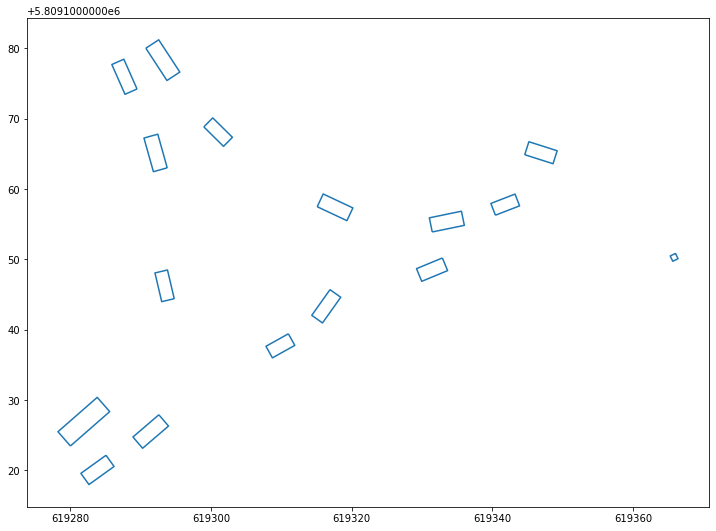

In [731]:
fig, ax = plt.subplots(figsize=(16, 9))
gdf_t.set_geometry("bbox").boundary.plot(ax=ax)

In [721]:
background_image = mpimg.imread(r'..\data\raw\rdb1\geo-referenced_images_rdb1\rdb1.png')

(-0.5, 3839.5, 2159.5, -0.5)

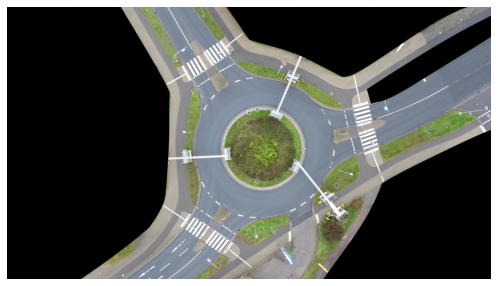

In [722]:
plt.figure(figsize=(15,5))
plt.imshow(background_image)
plt.axis("off")

In [723]:
background_image.shape[1]/background_image.shape[0]

1.7777777777777777

In [725]:
world_def = WorldDefinition.from_pgw_file(pathlib.Path(r'..\data\raw\rdb1\geo-referenced_images_rdb1\rdb1.pgw'))

In [726]:
world_def

WorldDefinition(x_scale=0.0311407714, y_scale=-0.0310992985, x_skew=-0.0032656759, y_skew=-0.0030169731, x_upper_left=619245.1776260373, y_upper_left=5809189.972152386)

In [727]:
world_def._get_affine_matrix()

array([[ 3.11407714e-02, -3.26567590e-03,  6.19245178e+05],
       [-3.01697310e-03, -3.10992985e-02,  5.80918997e+06]])

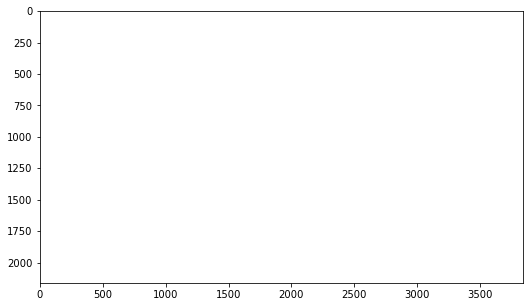

In [728]:
plt.figure(figsize=(15,5))
plt.imshow(A, cmap="Greys", vmin=0, vmax=1)

In [729]:
background_image.shape[:2][::-1]

(3840, 2160)

In [ ]:
rotated_img = ndimage.rotate(img, degree*60)

In [692]:
extent = world_def.get_image_extent(3840, 2160)

In [693]:
extent

(619245.1776260373, 619357.7043282692, 5809111.212490922, 5809189.972152386)

In [694]:
w, h = extent[1] - extent[0], extent[3] - extent[2]
w, h

(112.52670223196037, 78.75966146402061)

In [695]:
w/h

1.428735219784628

In [696]:
background_image.shape[1]/background_image.shape[0]

1.7777777777777777

<AxesSubplot:>

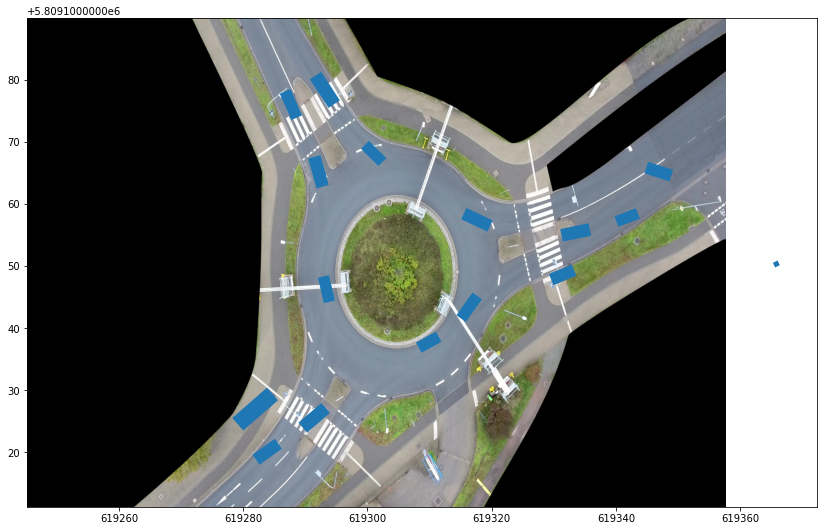

In [697]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(background_image, extent=extent, origin="upper", aspect="auto")
gdf_t.set_geometry("bbox").plot(ax=ax)

# cx.add_basemap(ax, crs=df_traces_vehicle.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom="auto")